<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 8.
## <center> Реализация алгоритмов онлайн-обучения

Вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD).

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [3]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [10]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy     : 1.25.2
scipy     : 1.11.2
pandas    : 2.1.0
matplotlib: 3.7.2
sklearn   : 0.0.post7

Compiler    : MSC v.1936 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit



##  1.1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [108]:
class SGDRegressor(BaseEstimator):
    def __init__(self, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.mse_ = []
        self.weights_ = []

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        w = np.zeros(X.shape[1])

        for it in range(self.n_iter):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[j] - w.dot(X[i, :])) * X[i, j]

                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))
                
        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self

    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        
        return X.dot(self.w_)

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [2]:
data_demo = pd.read_csv('weights_heights.csv')

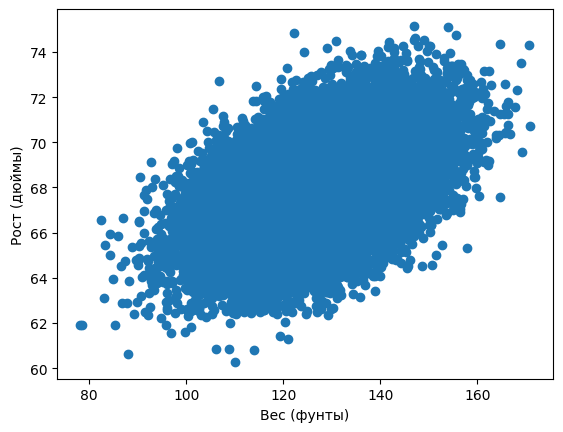

In [109]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [110]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [111]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [112]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

In [113]:
sgd = SGDRegressor()
sgd.fit(X_train_scaled, y_train)

SGDRegressor()

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

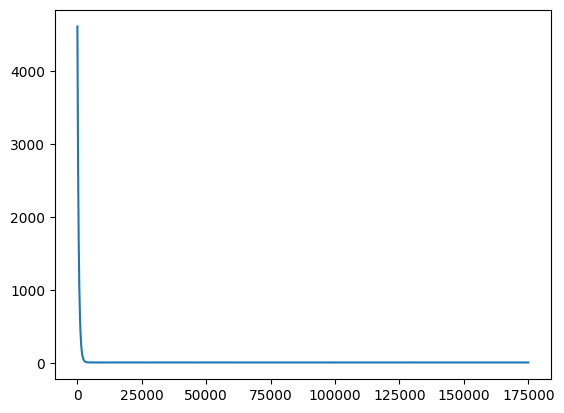

In [114]:
plt.plot(range(len(sgd.mse_)), sgd.mse_);

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [115]:
print(np.min(sgd.mse_))
print(sgd.w_)

3.2990485247159644
[68.00394051  0.18136998]


Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

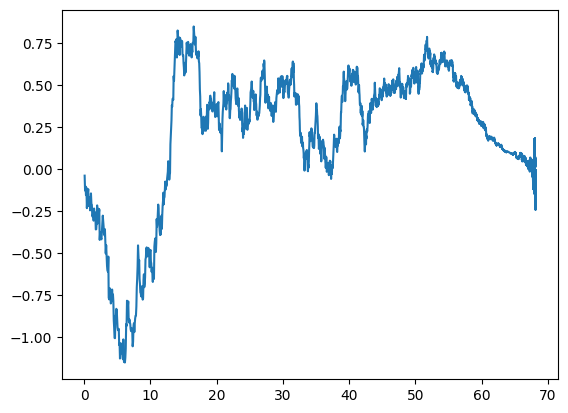

In [116]:
plt.plot([w[0] for w in sgd.weights_], 
         [w[1] for w in sgd.weights_]);

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [117]:
mean_squared_error(y_valid, sgd.predict(X_valid_scaled))

3.304951566283936

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [118]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [119]:
mean_squared_error(y_valid, lr.predict(X_valid_scaled))

2.670830767667635

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

In [120]:
# 4 формула

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [127]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [128]:
class SGDClassifier(BaseEstimator):
    def __init__(self, C, eta=1e-3, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        self.C = C
        self.loss_ = []
        self.weights_ = []

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        w = np.zeros(X.shape[1])

        for it in range(self.n_iter):
            for i in range(X.shape[0]):
                new_w = w.copy()

                new_w[0] += self.eta * self.C * sigma(-y[i] * w.dot(X[i, :])) * y[i]

                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (self.C * sigma(-y[i] * w.dot(X[i, :])) * y[i] * X[i, j] - w[j])

                w = new_w.copy()
                
                self.loss_.append(log_loss(y, sigma(X.dot(w))))
                self.weights_.append(w)
    
        self.w_ = self.weights_[np.argmin(self.loss_)]
        return self

    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        p_vec = sigma(X.dot(self.w_)).reshape([X.shape[0], 1])
        return np.hstack([1 - p_vec, p_vec])
    
    def predict(self, X):
        pred_probs = self.predict_proba(X)[:, 1]
        signs = np.sign(pred_probs - 0.5)
        signs[np.where(signs == 0)] = 1
        return signs

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [150]:
from sklearn.datasets import load_breast_cancer

In [190]:
cancer = load_breast_cancer()
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [191]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)


In [192]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

In [199]:
sgd_clf = SGDClassifier(C=1, n_iter=3, eta=1e-3)
sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(C=1, n_iter=3)

Постройте график изменения log_loss.

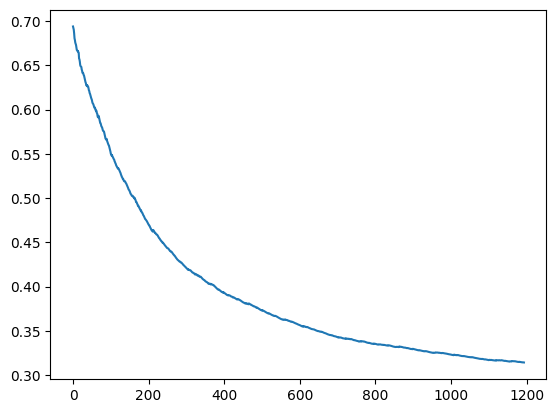

In [202]:
plt.plot(range(len(sgd_clf.loss_)), sgd_clf.loss_);

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

In [201]:
new_sgd_clf = SGDClassifier(C=1e3, n_iter=10)
new_sgd_clf.fit(X_train_scaled, y_train)

SGDClassifier(C=1000.0)

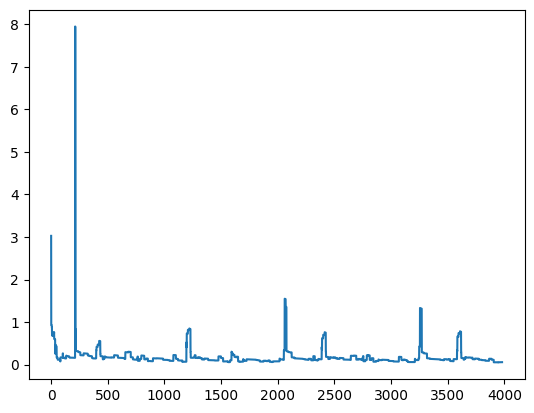

In [205]:
plt.plot(range(len(new_sgd_clf.loss_)), new_sgd_clf.loss_);

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [217]:
pd.DataFrame({'coef': new_sgd_clf.weights_[np.argmin(new_sgd_clf.loss_)],
             'feat': ['intercept'] + list(cancer.feature_names)}).sort_values(by='coef')

,coef,feat
27,-5.107343,worst concavity
11,-4.531819,radius error
22,-4.051564,worst texture
7,-3.566910,mean concavity
8,-3.543276,mean concave points
2,-3.413874,mean texture
14,-3.154584,area error
21,-2.924186,worst radius
13,-2.575289,perimeter error
24,-2.511385,worst area


In [218]:
# Признак, который влияет сильнее - worst concavity

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [221]:
log_loss(y_valid, new_sgd_clf.predict_proba(X_valid_scaled)[:, 1])

0.4344110793957911

In [222]:
roc_auc_score(y_valid, new_sgd_clf.predict_proba(X_valid_scaled)[:, 1])

0.9763040238450075

In [225]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=17)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=17)

In [226]:
log_loss(y_valid, lr.predict_proba(X_valid_scaled)[:, 1])

0.10855223162447498

In [227]:
roc_auc_score(y_valid, lr.predict_proba(X_valid_scaled)[:, 1])

0.9885245901639343